In [1]:
import numpy as np
import os
os.environ["SCIPY_USE_PROPACK"] = "True"
import scipy
from scipy.sparse.linalg import svds
import quimb as qu

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [257]:
# Initial conditions for TDJ
def J(X, Y, u_0, y_min=0.4, y_max=0.6, h = 0.005):
    return u_0/2*(np.tanh((Y-y_min)/h)-np.tanh((Y-y_max)/h)-1), np.zeros_like(Y)

def d_1(X, Y, y_min=0.4, y_max=0.6, h=0.005, L_box=1):
    return 2*L_box/h**2*((Y-y_max)*np.exp(-(Y-y_max)**2/h**2)+(Y-y_min)*np.exp(-(Y-y_min)**2/h**2))*(np.sin(8*np.pi*X/L_box)+np.sin(24*np.pi*X/L_box)+np.sin(6*np.pi*X/L_box))

def d_2(X, Y, y_min=0.4, y_max=0.6, h=0.005, L_box=1):
    return np.pi*(np.exp(-(Y-y_max)**2/h**2)+np.exp(-(Y-y_min)**2/h**2))*(8*np.cos(8*np.pi*X/L_box)+24*np.cos(24*np.pi*X/L_box)+6*np.cos(6*np.pi*X/L_box))

def D(X, Y, u_0, y_min, y_max, h, L_box):
    d1 = d_1(X, Y, y_min, y_max, h, L_box)
    d2 = d_2(X, Y, y_min, y_max, h, L_box)
    delta = u_0/(40*np.max(np.sqrt(d1**2+d2**2)))
    return delta*d1, delta*d2

In [258]:
def CreateFields2D(L, N, y_min, y_max, h, u_max):
    dx = L/N    # dx=dy

    # create 2D grid
    x = np.linspace(0, L-dx, N)
    y = np.linspace(0, L-dx, N)
    Y, X = np.meshgrid(y, x)

    # load initial conditions for TDJ
    U, V = J(X, Y, u_max, y_min, y_max, h)
    dU, dV = D(X, Y, u_max, y_min, y_max, h, L)
    U = U + dU
    V = V + dV

    return U, V

In [260]:
def get_F_index(binary):
    # get index in original array
    # binary = sig_1^x sig_1^y ... sig_n_bits^x sig_n_bits^y
    # F_index = sig_1^x sig_2^x ... sig_n_bits^x sig_1^y sig_2^y ... sig_n_bits^y
    return int(binary[::2]+binary[1::2], 2)

In [261]:
def svd(mat, k):
    # Perform truncated singular value decomposition 
    chi_k = np.min(mat.shape)-1
    if k < chi_k:
        chi_k = k
    U, S, V = svds(mat, chi_k)
    m, n = mat.shape
    d_min = min(m, n)
    U_full = np.zeros((m, d_min))
    S_full = np.zeros((d_min, d_min))
    V_full = np.zeros((d_min, n))
    m, n = U.shape
    U_full[:m, :n] = U
    S_full[:chi_k, :chi_k] = np.diag(S)
    m, n = V.shape
    V_full[:m, :n] = V

    return U_full, S_full, V_full

In [262]:
from scipy.linalg import svd as svd_s

def plain_svd(mat):
    U, S, V = svd_s(mat, full_matrices=False)

    return U, np.diag(S), V

In [263]:
def convert_to_MPS2D(F, chi=None):
    Nx, Ny = F.shape            # Get number of points (Nx equals Ny)
    n = int(np.log2(Nx))        # Get number of (qu)bits
    F_vec = F.reshape((1, -1))  # Flatten function
    
    # Reshape into scale resolving representation C
    w = '0'*2*n                                 # index sig_1^x sig_1^y ... sig_n_bits^x sig_n_bits^y
    C_vec = np.zeros(4**n).reshape((1, -1))     # similar to F but with scale indices

    for _ in range(4**n):
        F_index = get_F_index(w)                # get original index for w
        C_index = int(w, 2)                     # get corresponding index for w
        w = bin(C_index+1)[2:].zfill(2*n)       # set w += 1 in binary
        C_vec[0, C_index] = F_vec[0, F_index]   

    node = C_vec    # set first node of MPS
    MPS = []        # create MPS as list of matrices
    S_mats = []     # create list for singular value matrices 

    for i in range(n-1):
        # node = expand_rows(node, 4)     # move first index from columns to rows
        m, n = node.shape
        node = node.reshape((4*m, int(n/4)))
        if chi == None:
            U, S, V = plain_svd(node)
        else:
            U, S, V = svd(node, chi)        # perform truncated SVD
        MPS.append(U)                   # save U as first node of MPS
        S_mats.append(S)                # save S
        node = np.matmul(S, V)          # create remaining matrix S*V for next expansion step

    m, n = node.shape
    node = node.reshape((4*m, int(n/4)))
    MPS.append(node)    # add last node to MPS

    return MPS

In [264]:
def convert_to_MPS2D_n(F, chi=None):
    Nx, Ny = F.shape            # Get number of points (Nx equals Ny)
    n = int(np.log2(Nx))        # Get number of (qu)bits
    F_vec = F.reshape((1, -1))  # Flatten function

    node = F_vec    # set first node of MPS
    MPS = []        # create MPS as list of matrices
    S_mats = []     # create list for singular value matrices 

    for i in range(n-1):
        # node = expand_rows(node, 4)     # move first index from columns to rows
        m, n = node.shape
        node = node.reshape((4*m, int(n/4)))
        if chi == None:
            U, S, V = plain_svd(node)
        else:
            U, S, V = svd(node, chi)        # perform truncated SVD
        MPS.append(U)                   # save U as first node of MPS
        S_mats.append(S)                # save S
        node = np.matmul(S, V)          # create remaining matrix S*V for next expansion step

    m, n = node.shape
    node = node.reshape((4*m, int(n/4)))
    MPS.append(node)    # add last node to MPS

    return MPS

In [265]:
def convert_to_VF2D(MPS):
    n_bits = len(MPS)
    N = 2**n_bits
    node_L = MPS[0]
    for i in range(1, n_bits):
        m, n = node_L.shape
        node_R = MPS[i].reshape((n, -1))
        node_L = np.matmul(node_L, node_R)
        m, n = node_L.shape
        node_L = node_L.reshape((4*m, int(n/4)))
    C_vec = node_L.reshape((1, -1)) 

    w = '0'*2*n_bits                            # index sig_1^x sig_1^y ... sig_n_bits^x sig_n_bits^y
    F_vec = np.zeros(4**n_bits).reshape((1, -1))     # similar to C but with dimensional indices

    for _ in range(4**n_bits):
        F_index = get_F_index(w)             
        C_index = int(w, 2)                   
        w = bin(C_index+1)[2:].zfill(2*n_bits)     
        F_vec[0, F_index]  = C_vec[0, C_index]

    return F_vec.reshape((N, N))

In [266]:
def convert_MPS_to_quimb(tensor_list, dim_ls):
    arrays = []
    for i, tensor in enumerate(tensor_list):
        m, n = tensor.shape
        dim_left_bond = int(m/dim_ls)
        dim_right_bond = n
        data = tensor.reshape((dim_left_bond, dim_ls, dim_right_bond))
        arrays.append(data)
    
    return qu.tensor.MatrixProductState(arrays, shape='lpr')


In [267]:
def convert_quimb_to_MPS(quimb_MPS):
    MPS = []
    for array in quimb_MPS.arrays:
        l, r, p = array.shape
        MPS.append(np.transpose(array, (0, 2, 1)).reshape((l*p, r)))
    
    return MPS

In [268]:
# Build 2D TDJ in quimb MPS form
def buildFluidField2DMPS():
    # Create field
    n_bits = 10
    N = 2**n_bits
    L = 1
    chi = N

    # Initial conditions
    y_min = 0.4
    y_max = 0.6
    h = 1/200 
    u_max = 1
    epsilon = 10^-8

    # Set timesteps
    dt = 0.1*2**-(n_bits-1)
    T = 2

    # Set penalty factor for breach of incompressibility condition
    dx = 2**-n_bits
    lam = dx**2 * 10**4

    # Generate initial fields
    U, V = CreateFields2D(L, N, y_min, y_max, h, u_max) 

    # Rescale into non-dimensional units
    U = U/u_max
    V = V/u_max

    # Convert them to MPS form
    MPS_U = convert_to_MPS2D(U, chi)
    MPS_V = convert_to_MPS2D(V, chi)

    # Tranform into quimb MPS form
    MPS_U_quimb = convert_MPS_to_quimb(MPS_U, 4)
    MPS_V_quimb = convert_MPS_to_quimb(MPS_V, 4)

    return MPS_U_quimb, MPS_V_quimb, MPS_U, MPS_V

In [269]:
def Diff_1_2_y_MPO(n, dx):
    # first order derivative with second order precision in y direction
    # tensor stucture:
    #                          |
    # left_terminator - (central_node)^n - right_terminator
    #                          |
    left_terminator = np.array([1, 1, 1]).reshape(1, 3)
    central_node = np.zeros((4, 3, 4, 3))   # down, left, up, right
    # 0 from right: identity
    central_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    central_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    central_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    central_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    central_node[0, 0, 1, 1] = 1    # 00 -> 01 no carry (0)
    central_node[1, 1, 0, 1] = 1    # 01 -> 00 carry for addition (1)
    central_node[2, 0, 3, 1] = 1    # 10 -> 11 no carry (0)
    central_node[3, 1, 2, 1] = 1    # 11 -> 10 carry for addition (1)
    # 2 from right: substract 1
    central_node[0, 2, 1, 2] = 1    # 00 -> 01 carry for substraction (2)
    central_node[1, 0, 0, 2] = 1    # 01 -> 00 no carry (0)
    central_node[2, 2, 3, 2] = 1    # 10 -> 11 carry for substraction (2)
    central_node[3, 0, 2, 2] = 1    # 11 -> 10 no carry(0)
    right_terminator = 1/dx*np.array([0, 1/2, -1/2]).reshape(3, 1) # coefficients

    # Define arrays for MPO
    left_node = np.matmul(left_terminator, central_node.transpose(1, 0, 2, 3).reshape(3, -1)).reshape(1, 4, 4, 3).transpose(1, 0, 2, 3)
    right_node = np.matmul(central_node.reshape(-1, 3), right_terminator).reshape(4, 3, 4, 1)
    arrays = [left_node] + [central_node]*(n-2) + [right_node]

    # Create quimb MPO
    MPO = qu.tensor.MatrixProductOperator(arrays, shape='dlur')

    return MPO

In [270]:
def Diff_1_2_x_MPO(n, dx):
    # first order derivative with second order precision in x direction
    # tensor stucture:
    #                          |
    # left_terminator - (central_node)^n - right_terminator
    #                          |
    left_terminator = np.array([1, 1, 1]).reshape(1, 3)
    central_node = np.zeros((4, 3, 4, 3))   # down, left, up, right
    # 0 from right: identity
    central_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    central_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    central_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    central_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    central_node[0, 0, 2, 1] = 1    # 00 -> 10 no carry (0)
    central_node[1, 0, 3, 1] = 1    # 01 -> 11 no carry (0)
    central_node[2, 1, 0, 1] = 1    # 10 -> 00 carry for addition (1)
    central_node[3, 1, 1, 1] = 1    # 11 -> 01 carry for addition (1)
    # 2 from right: substract 1
    central_node[0, 2, 2, 2] = 1    # 00 -> 10 carry for substraction (2)
    central_node[1, 2, 3, 2] = 1    # 01 -> 11 carry for substraction (2)
    central_node[2, 0, 0, 2] = 1    # 10 -> 00 no carry (0)
    central_node[3, 0, 1, 2] = 1    # 11 -> 01 no carry (0)
    right_terminator = 1/dx*np.array([0, 1/2, -1/2]).reshape(3, 1) # coefficients

    # Define arrays for MPO
    left_node = np.matmul(left_terminator, central_node.transpose(1, 0, 2, 3).reshape(3, -1)).reshape(1, 4, 4, 3).transpose(1, 0, 2, 3)
    right_node = np.matmul(central_node.reshape(-1, 3), right_terminator).reshape(4, 3, 4, 1)
    arrays = [left_node] + [central_node]*(n-2) + [right_node]

    # Create quimb MPO
    MPO = qu.tensor.MatrixProductOperator(arrays, shape='dlur')

    return MPO

In [271]:
def Diff_2_2_y_MPO(n, dx):
    # second order derivative with second order precision in y direction
    # tensor stucture:
    #                          |
    # left_terminator - (central_node)^n - right_terminator
    #                          
    left_terminator = np.array([1, 1, 1]).reshape(1, 3)
    central_node = np.zeros((4, 3, 4, 3))   # down, left, up, right
    # 0 from right: identity
    central_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    central_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    central_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    central_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    central_node[0, 0, 1, 1] = 1    # 00 -> 01 no carry (0)
    central_node[1, 1, 0, 1] = 1    # 01 -> 00 carry for addition (1)
    central_node[2, 0, 3, 1] = 1    # 10 -> 11 no carry (0)
    central_node[3, 1, 2, 1] = 1    # 11 -> 10 carry for addition (1)
    # 2 from right: substract 1
    central_node[0, 2, 1, 2] = 1    # 00 -> 01 carry for substraction (2)
    central_node[1, 0, 0, 2] = 1    # 01 -> 00 no carry (0)
    central_node[2, 2, 3, 2] = 1    # 10 -> 11 carry for substraction (2)
    central_node[3, 0, 2, 2] = 1    # 11 -> 10 no carry(0)
    right_terminator = 1/dx**2*np.array([-2, 1, 1]).reshape(3, 1) # coefficients

    # Define arrays for MPO
    left_node = np.matmul(left_terminator, central_node.transpose(1, 0, 2, 3).reshape(3, -1)).reshape(1, 4, 4, 3).transpose(1, 0, 2, 3)
    right_node = np.matmul(central_node.reshape(-1, 3), right_terminator).reshape(4, 3, 4, 1)
    arrays = [left_node] + [central_node]*(n-2) + [right_node]

    # Create quimb MPO
    MPO = qu.tensor.MatrixProductOperator(arrays, shape='dlur')

    return MPO

In [272]:
def Diff_2_2_x_MPO(n, dx):
    # second order derivative with second order precision in x direction
    # tensor stucture:
    #                          |
    # left_terminator - (central_node)^n - right_terminator
    #                          |
    left_terminator = np.array([1, 1, 1]).reshape(1, 3)
    central_node = np.zeros((4, 3, 4, 3))   # down, left, up, right
    # 0 from right: identity
    central_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    central_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    central_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    central_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    central_node[0, 0, 2, 1] = 1    # 00 -> 10 no carry (0)
    central_node[1, 0, 3, 1] = 1    # 01 -> 11 no carry (0)
    central_node[2, 1, 0, 1] = 1    # 10 -> 00 carry for addition (1)
    central_node[3, 1, 1, 1] = 1    # 11 -> 01 carry for addition (1)
    # 2 from right: substract 1
    central_node[0, 2, 2, 2] = 1    # 00 -> 10 carry for substraction (2)
    central_node[1, 2, 3, 2] = 1    # 01 -> 11 carry for substraction (2)
    central_node[2, 0, 0, 2] = 1    # 10 -> 00 no carry (0)
    central_node[3, 0, 1, 2] = 1    # 11 -> 01 no carry (0)
    right_terminator = 1/dx**2*np.array([-2, 1, 1]).reshape(3, 1) # coefficients

    # Define arrays for MPO
    left_node = np.matmul(left_terminator, central_node.transpose(1, 0, 2, 3).reshape(3, -1)).reshape(1, 4, 4, 3).transpose(1, 0, 2, 3)
    right_node = np.matmul(central_node.reshape(-1, 3), right_terminator).reshape(4, 3, 4, 1)
    arrays = [left_node] + [central_node]*(n-2) + [right_node]

    # Create quimb MPO
    MPO = qu.tensor.MatrixProductOperator(arrays, shape='dlur')

    return MPO

In [273]:
def Diff_1_8_y_MPO(n, dx):
    # first order derivative with eigth order precision in y direction
    # tensor stucture:
    #                          |                         |               |
    # left_terminator - (central_node)^(n-2) - second to last node - last node - right_terminator
    #                          |                         |               |
    # left terminator
    left_terminator = np.array([1, 1, 1]).reshape(1, 3)
    # central node
    central_node = np.zeros((4, 3, 4, 3))   # down, left, up, right
    # 0 from right: identity
    central_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    central_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    central_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    central_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    central_node[0, 0, 1, 1] = 1    # 00 -> 01 no carry (0)
    central_node[1, 1, 0, 1] = 1    # 01 -> 00 carry for addition (1)
    central_node[2, 0, 3, 1] = 1    # 10 -> 11 no carry (0)
    central_node[3, 1, 2, 1] = 1    # 11 -> 10 carry for addition (1)
    # 2 from right: substract 1
    central_node[0, 2, 1, 2] = 1    # 00 -> 01 carry for substraction (2)
    central_node[1, 0, 0, 2] = 1    # 01 -> 00 no carry (0)
    central_node[2, 2, 3, 2] = 1    # 10 -> 11 carry for substraction (2)
    central_node[3, 0, 2, 2] = 1    # 11 -> 10 no carry(0)
    # second to last node
    sec_last_node = np.zeros((4, 3, 4, 5))  # down, left, up, right
    # 0 from right: identity
    sec_last_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    sec_last_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    sec_last_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    sec_last_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    sec_last_node[0, 0, 1, 1] = 1    # 00 -> 01 no carry (0)
    sec_last_node[1, 1, 0, 1] = 1    # 01 -> 00 carry for addition (1)
    sec_last_node[2, 0, 3, 1] = 1    # 10 -> 11 no carry (0)
    sec_last_node[3, 1, 2, 1] = 1    # 11 -> 10 carry for addition (1)
    # 2 from right: substract 1
    sec_last_node[0, 2, 1, 2] = 1    # 00 -> 01 carry for substraction (2)
    sec_last_node[1, 0, 0, 2] = 1    # 01 -> 00 no carry (0)
    sec_last_node[2, 2, 3, 2] = 1    # 10 -> 11 carry for substraction (2)
    sec_last_node[3, 0, 2, 2] = 1    # 11 -> 10 no carry (0)
    # 3 from right: identity with carry for addition
    sec_last_node[0, 1, 0, 3] = 1    # 00 -> 00 carry for addition (1)
    sec_last_node[1, 1, 1, 3] = 1    # 01 -> 01 carry for addition (1)
    sec_last_node[2, 1, 2, 3] = 1    # 10 -> 10 carry for addition (1)
    sec_last_node[3, 1, 3, 3] = 1    # 11 -> 11 carry for addition (1)
    # 4 from right: identity with carry for substraction
    sec_last_node[0, 2, 0, 4] =  1   # 00 -> 00 carry for substraction (2)
    sec_last_node[1, 2, 1, 4] =  1   # 01 -> 01 carry for substraction (2)
    sec_last_node[2, 2, 2, 4] =  1   # 10 -> 10 carry for substraction (2)
    sec_last_node[3, 2, 3, 4] =  1   # 11 -> 11 carry for substraction (2)
    # last node
    last_node = np.zeros((4, 5, 4, 6))  # down, left, up, right
    # 0 from right: identity
    last_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    last_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    last_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    last_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    last_node[0, 0, 1, 1] = 1    # 00 -> 01 no carry (0)
    last_node[1, 1, 0, 1] = 1    # 01 -> 00 carry for addition (1)
    last_node[2, 0, 3, 1] = 1    # 10 -> 11 no carry (0)
    last_node[3, 1, 2, 1] = 1    # 11 -> 10 carry for addition (1)
    # 2 from right: substract 1
    last_node[0, 2, 1, 2] = 1    # 00 -> 01 carry for substraction (2)
    last_node[1, 0, 0, 2] = 1    # 01 -> 00 no carry (0)
    last_node[2, 2, 3, 2] = 1    # 10 -> 11 carry for substraction (2)
    last_node[3, 0, 2, 2] = 1    # 11 -> 10 no carry (0)
    # 3 from right: add and substract 2
    last_node[0, 1, 0, 3] = 1    # 00 -> 00 carry for addition (1)
    last_node[1, 1, 1, 3] = 1    # 01 -> 01 carry for addition (1)
    last_node[2, 1, 2, 3] = 1    # 10 -> 10 carry for addition (1)
    last_node[3, 1, 3, 3] = 1    # 11 -> 11 carry for addition (1)
    last_node[0, 2, 0, 3] = -1   # 00 -> 00 carry for substraction (2)
    last_node[1, 2, 1, 3] = -1   # 01 -> 01 carry for substraction (2)
    last_node[2, 2, 2, 3] = -1   # 10 -> 10 carry for substraction (2)
    last_node[3, 2, 3, 3] = -1   # 11 -> 11 carry for substraction (2)
    # 4 from right: add and substract 3
    last_node[0, 1, 1, 4] = 1    # 00 -> 01 carry for addition (1)
    last_node[1, 3, 0, 4] = 1    # 01 -> 00 carry for addition one further (3)
    last_node[2, 1, 3, 4] = 1    # 10 -> 11 carry for addition (1)
    last_node[3, 3, 2, 4] = 1    # 11 -> 10 carry for addition one further (3)
    last_node[0, 4, 1, 4] = -1   # 00 -> 01 carry for substraction one further (4)
    last_node[1, 2, 0, 4] = -1   # 01 -> 00 carry for substraction (2)
    last_node[2, 4, 3, 4] = -1   # 10 -> 11 carry for substraction one further (4)
    last_node[3, 2, 2, 4] = -1   # 11 -> 10 carry for substraction (2)
    # 5 from right: add and substract 4
    last_node[0, 3, 0, 5] = 1    # 00 -> 00 carry for addition one further (3)
    last_node[1, 3, 1, 5] = 1    # 01 -> 01 carry for addition one further (3)
    last_node[2, 3, 2, 5] = 1    # 10 -> 10 carry for addition one further (3)
    last_node[3, 3, 3, 5] = 1    # 11 -> 11 carry for addition one further (3)
    last_node[0, 4, 0, 5] = -1   # 00 -> 00 carry for substraction one further (4)
    last_node[1, 4, 1, 5] = -1   # 01 -> 01 carry for substraction one further (4)
    last_node[2, 4, 2, 5] = -1   # 10 -> 10 carry for substraction one further (4)
    last_node[3, 4, 3, 5] = -1   # 11 -> 11 carry for substraction one further (4)
    # right terminator
    right_terminator = 1/dx*np.array([0, 4/5, -4/5, -1/5, 4/105, -1/280]).reshape(6, 1) # coefficients

    # Define arrays for MPO
    left_node = np.matmul(left_terminator, central_node.transpose(1, 0, 2, 3).reshape(3, -1)).reshape(1, 4, 4, 3).transpose(1, 0, 2, 3)
    right_node = np.matmul(last_node.reshape(-1, 6), right_terminator).reshape(4, 5, 4, 1)
    arrays = [left_node] + [central_node]*(n-3) + [sec_last_node] + [right_node]

    # Create quimb MPO
    MPO = qu.tensor.MatrixProductOperator(arrays, shape='dlur')

    return MPO

In [274]:
def Diff_1_8_x_MPO(n, dx):
    # first order derivative with eighth order precision in x direction
    # tensor stucture:
    #                          |                         |               |
    # left_terminator - (central_node)^(n-2) - second to last node - last node - right_terminator
    #                          |                         |               |
    # left terminator
    left_terminator = np.array([1, 1, 1]).reshape(1, 3)
    # central node
    central_node = np.zeros((4, 3, 4, 3))   # down, left, up, right
    # 0 from right: identity
    central_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    central_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    central_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    central_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    central_node[0, 0, 2, 1] = 1    # 00 -> 10 no carry (0)
    central_node[1, 0, 3, 1] = 1    # 01 -> 11 no carry (0)
    central_node[2, 1, 0, 1] = 1    # 10 -> 00 carry for addition (1)
    central_node[3, 1, 1, 1] = 1    # 11 -> 01 carry for addition (1)
    # 2 from right: substract 1
    central_node[0, 2, 2, 2] = 1    # 00 -> 10 carry for substraction (2)
    central_node[1, 2, 3, 2] = 1    # 01 -> 11 carry for substraction (2)
    central_node[2, 0, 0, 2] = 1    # 10 -> 00 no carry (0)
    central_node[3, 0, 1, 2] = 1    # 11 -> 01 no carry (0)
    # second to last node
    sec_last_node = np.zeros((4, 3, 4, 5))  # down, left, up, right
    # 0 from right: identity
    sec_last_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    sec_last_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    sec_last_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    sec_last_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    sec_last_node[0, 0, 2, 1] = 1    # 00 -> 10 no carry (0)
    sec_last_node[1, 0, 3, 1] = 1    # 01 -> 11 no carry (0)
    sec_last_node[2, 1, 0, 1] = 1    # 10 -> 00 carry for addition (1)
    sec_last_node[3, 1, 1, 1] = 1    # 11 -> 01 carry for addition (1)
    # 2 from right: substract 1
    sec_last_node[0, 2, 2, 2] = 1    # 00 -> 10 carry for substraction (2)
    sec_last_node[1, 2, 3, 2] = 1    # 01 -> 11 carry for substraction (2)
    sec_last_node[2, 0, 0, 2] = 1    # 10 -> 00 no carry (0)
    sec_last_node[3, 0, 1, 2] = 1    # 11 -> 01 no carry (0)
    # 3 from right: identity with carry for addition
    sec_last_node[0, 1, 0, 3] = 1    # 00 -> 00 carry for addition (1)
    sec_last_node[1, 1, 1, 3] = 1    # 01 -> 01 carry for addition (1)
    sec_last_node[2, 1, 2, 3] = 1    # 10 -> 10 carry for addition (1)
    sec_last_node[3, 1, 3, 3] = 1    # 11 -> 11 carry for addition (1)
    # 4 from right: identity with carry for substraction
    sec_last_node[0, 2, 0, 4] =  1   # 00 -> 00 carry for substraction (2)
    sec_last_node[1, 2, 1, 4] =  1   # 01 -> 01 carry for substraction (2)
    sec_last_node[2, 2, 2, 4] =  1   # 10 -> 10 carry for substraction (2)
    sec_last_node[3, 2, 3, 4] =  1   # 11 -> 11 carry for substraction (2)
    # last node
    last_node = np.zeros((4, 5, 4, 6))  # down, left, up, right
    # 0 from right: identity
    last_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    last_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    last_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    last_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    last_node[0, 0, 2, 1] = 1    # 00 -> 10 no carry (0)
    last_node[1, 0, 3, 1] = 1    # 01 -> 11 no carry (0)
    last_node[2, 1, 0, 1] = 1    # 10 -> 00 carry for addition (1)
    last_node[3, 1, 1, 1] = 1    # 11 -> 01 carry for addition (1)
    # 2 from right: substract 1
    last_node[0, 2, 2, 2] = 1    # 00 -> 10 carry for substraction (2)
    last_node[1, 2, 3, 2] = 1    # 01 -> 11 carry for substraction (2)
    last_node[2, 0, 0, 2] = 1    # 10 -> 00 no carry (0)
    last_node[3, 0, 1, 2] = 1    # 11 -> 01 no carry (0)
    # 3 from right: add and substract 2
    last_node[0, 1, 0, 3] = 1    # 00 -> 00 carry for addition (1)
    last_node[1, 1, 1, 3] = 1    # 01 -> 01 carry for addition (1)
    last_node[2, 1, 2, 3] = 1    # 10 -> 10 carry for addition (1)
    last_node[3, 1, 3, 3] = 1    # 11 -> 11 carry for addition (1)
    last_node[0, 2, 0, 3] = -1   # 00 -> 00 carry for substraction (2)
    last_node[1, 2, 1, 3] = -1   # 01 -> 01 carry for substraction (2)
    last_node[2, 2, 2, 3] = -1   # 10 -> 10 carry for substraction (2)
    last_node[3, 2, 3, 3] = -1   # 11 -> 11 carry for substraction (2)
    # 4 from right: add and substract 3
    last_node[0, 1, 2, 4] = 1    # 00 -> 10 carry for addition (1)
    last_node[1, 1, 3, 4] = 1    # 01 -> 11 carry for addition (1)
    last_node[2, 3, 0, 4] = 1    # 10 -> 00 carry for addition one further (3)
    last_node[3, 3, 1, 4] = 1    # 11 -> 01 carry for addition one further (3)
    last_node[0, 4, 2, 4] = -1   # 00 -> 10 carry for substraction one further (4)
    last_node[1, 4, 3, 4] = -1   # 01 -> 11 carry for substraction one further (4)
    last_node[2, 2, 0, 4] = -1   # 10 -> 00 carry for substraction (2)
    last_node[3, 2, 1, 4] = -1   # 11 -> 01 carry for substraction (2)
    # 5 from right: add and substract 4
    last_node[0, 3, 0, 5] = 1    # 00 -> 00 carry for addition one further (3)
    last_node[1, 3, 1, 5] = 1    # 01 -> 01 carry for addition one further (3)
    last_node[2, 3, 2, 5] = 1    # 10 -> 10 carry for addition one further (3)
    last_node[3, 3, 3, 5] = 1    # 11 -> 11 carry for addition one further (3)
    last_node[0, 4, 0, 5] = -1   # 00 -> 00 carry for substraction one further (4)
    last_node[1, 4, 1, 5] = -1   # 01 -> 01 carry for substraction one further (4)
    last_node[2, 4, 2, 5] = -1   # 10 -> 10 carry for substraction one further (4)
    last_node[3, 4, 3, 5] = -1   # 11 -> 11 carry for substraction one further (4)
    # right terminator
    right_terminator = 1/dx*np.array([0, 4/5, -4/5, -1/5, 4/105, -1/280]).reshape(6, 1) # coefficients

    # Define arrays for MPO
    left_node = np.matmul(left_terminator, central_node.transpose(1, 0, 2, 3).reshape(3, -1)).reshape(1, 4, 4, 3).transpose(1, 0, 2, 3)
    right_node = np.matmul(last_node.reshape(-1, 6), right_terminator).reshape(4, 5, 4, 1)
    arrays = [left_node] + [central_node]*(n-3) + [sec_last_node] + [right_node]

    # Create quimb MPO
    MPO = qu.tensor.MatrixProductOperator(arrays, shape='dlur')

    return MPO

In [275]:
def Diff_2_8_y_MPO(n, dx):
    # second order derivative with eigth order precision in y direction
    # tensor stucture:
    #                          |                         |               |
    # left_terminator - (central_node)^(n-2) - second to last node - last node - right_terminator
    #                          |                         |               |
    # left terminator
    left_terminator = np.array([1, 1, 1]).reshape(1, 3)
    # central node
    central_node = np.zeros((4, 3, 4, 3))   # down, left, up, right
    # 0 from right: identity
    central_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    central_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    central_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    central_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    central_node[0, 0, 1, 1] = 1    # 00 -> 01 no carry (0)
    central_node[1, 1, 0, 1] = 1    # 01 -> 00 carry for addition (1)
    central_node[2, 0, 3, 1] = 1    # 10 -> 11 no carry (0)
    central_node[3, 1, 2, 1] = 1    # 11 -> 10 carry for addition (1)
    # 2 from right: substract 1
    central_node[0, 2, 1, 2] = 1    # 00 -> 01 carry for substraction (2)
    central_node[1, 0, 0, 2] = 1    # 01 -> 00 no carry (0)
    central_node[2, 2, 3, 2] = 1    # 10 -> 11 carry for substraction (2)
    central_node[3, 0, 2, 2] = 1    # 11 -> 10 no carry(0)
    # second to last node
    sec_last_node = np.zeros((4, 3, 4, 5))  # down, left, up, right
    # 0 from right: identity
    sec_last_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    sec_last_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    sec_last_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    sec_last_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    sec_last_node[0, 0, 1, 1] = 1    # 00 -> 01 no carry (0)
    sec_last_node[1, 1, 0, 1] = 1    # 01 -> 00 carry for addition (1)
    sec_last_node[2, 0, 3, 1] = 1    # 10 -> 11 no carry (0)
    sec_last_node[3, 1, 2, 1] = 1    # 11 -> 10 carry for addition (1)
    # 2 from right: substract 1
    sec_last_node[0, 2, 1, 2] = 1    # 00 -> 01 carry for substraction (2)
    sec_last_node[1, 0, 0, 2] = 1    # 01 -> 00 no carry (0)
    sec_last_node[2, 2, 3, 2] = 1    # 10 -> 11 carry for substraction (2)
    sec_last_node[3, 0, 2, 2] = 1    # 11 -> 10 no carry (0)
    # 3 from right: identity with carry for addition
    sec_last_node[0, 1, 0, 3] = 1    # 00 -> 00 carry for addition (1)
    sec_last_node[1, 1, 1, 3] = 1    # 01 -> 01 carry for addition (1)
    sec_last_node[2, 1, 2, 3] = 1    # 10 -> 10 carry for addition (1)
    sec_last_node[3, 1, 3, 3] = 1    # 11 -> 11 carry for addition (1)
    # 4 from right: identity with carry for substraction
    sec_last_node[0, 2, 0, 4] =  1   # 00 -> 00 carry for substraction (2)
    sec_last_node[1, 2, 1, 4] =  1   # 01 -> 01 carry for substraction (2)
    sec_last_node[2, 2, 2, 4] =  1   # 10 -> 10 carry for substraction (2)
    sec_last_node[3, 2, 3, 4] =  1   # 11 -> 11 carry for substraction (2)
    # last node
    last_node = np.zeros((4, 5, 4, 6))  # down, left, up, right
    # 0 from right: identity
    last_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    last_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    last_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    last_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    last_node[0, 0, 1, 1] = 1    # 00 -> 01 no carry (0)
    last_node[1, 1, 0, 1] = 1    # 01 -> 00 carry for addition (1)
    last_node[2, 0, 3, 1] = 1    # 10 -> 11 no carry (0)
    last_node[3, 1, 2, 1] = 1    # 11 -> 10 carry for addition (1)
    # 2 from right: substract 1
    last_node[0, 2, 1, 2] = 1    # 00 -> 01 carry for substraction (2)
    last_node[1, 0, 0, 2] = 1    # 01 -> 00 no carry (0)
    last_node[2, 2, 3, 2] = 1    # 10 -> 11 carry for substraction (2)
    last_node[3, 0, 2, 2] = 1    # 11 -> 10 no carry (0)
    # 3 from right: add and substract 2
    last_node[0, 1, 0, 3] = 1    # 00 -> 00 carry for addition (1)
    last_node[1, 1, 1, 3] = 1    # 01 -> 01 carry for addition (1)
    last_node[2, 1, 2, 3] = 1    # 10 -> 10 carry for addition (1)
    last_node[3, 1, 3, 3] = 1    # 11 -> 11 carry for addition (1)
    last_node[0, 2, 0, 3] = 1    # 00 -> 00 carry for substraction (2)
    last_node[1, 2, 1, 3] = 1    # 01 -> 01 carry for substraction (2)
    last_node[2, 2, 2, 3] = 1    # 10 -> 10 carry for substraction (2)
    last_node[3, 2, 3, 3] = 1    # 11 -> 11 carry for substraction (2)
    # 4 from right: add and substract 3
    last_node[0, 1, 1, 4] = 1    # 00 -> 01 carry for addition (1)
    last_node[1, 3, 0, 4] = 1    # 01 -> 00 carry for addition one further (3)
    last_node[2, 1, 3, 4] = 1    # 10 -> 11 carry for addition (1)
    last_node[3, 3, 2, 4] = 1    # 11 -> 10 carry for addition one further (3)
    last_node[0, 4, 1, 4] = 1    # 00 -> 01 carry for substraction one further (4)
    last_node[1, 2, 0, 4] = 1    # 01 -> 00 carry for substraction (2)
    last_node[2, 4, 3, 4] = 1    # 10 -> 11 carry for substraction one further (4)
    last_node[3, 2, 2, 4] = 1    # 11 -> 10 carry for substraction (2)
    # 5 from right: add and substract 4
    last_node[0, 3, 0, 5] = 1    # 00 -> 00 carry for addition one further (3)
    last_node[1, 3, 1, 5] = 1    # 01 -> 01 carry for addition one further (3)
    last_node[2, 3, 2, 5] = 1    # 10 -> 10 carry for addition one further (3)
    last_node[3, 3, 3, 5] = 1    # 11 -> 11 carry for addition one further (3)
    last_node[0, 4, 0, 5] = 1    # 00 -> 00 carry for substraction one further (4)
    last_node[1, 4, 1, 5] = 1    # 01 -> 01 carry for substraction one further (4)
    last_node[2, 4, 2, 5] = 1    # 10 -> 10 carry for substraction one further (4)
    last_node[3, 4, 3, 5] = 1    # 11 -> 11 carry for substraction one further (4)
    # right terminator
    right_terminator = 1/dx**2*np.array([-205/72, 8/5, 8/5, -1/5, 8/315, -1/560]).reshape(6, 1) # coefficients

    # Define arrays for MPO
    left_node = np.matmul(left_terminator, central_node.transpose(1, 0, 2, 3).reshape(3, -1)).reshape(1, 4, 4, 3).transpose(1, 0, 2, 3)
    right_node = np.matmul(last_node.reshape(-1, 6), right_terminator).reshape(4, 5, 4, 1)
    arrays = [left_node] + [central_node]*(n-3) + [sec_last_node] + [right_node]

    # Create quimb MPO
    MPO = qu.tensor.MatrixProductOperator(arrays, shape='dlur')

    return MPO

In [276]:
def Diff_2_8_x_MPO(n, dx):
    # second order derivative with eighth order precision in x direction
    # tensor stucture:
    #                          |                         |               |
    # left_terminator - (central_node)^(n-2) - second to last node - last node - right_terminator
    #                          |                         |               |
    # left terminator
    left_terminator = np.array([1, 1, 1]).reshape(1, 3)
    # central node
    central_node = np.zeros((4, 3, 4, 3))   # down, left, up, right
    # 0 from right: identity
    central_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    central_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    central_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    central_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    central_node[0, 0, 2, 1] = 1    # 00 -> 10 no carry (0)
    central_node[1, 0, 3, 1] = 1    # 01 -> 11 no carry (0)
    central_node[2, 1, 0, 1] = 1    # 10 -> 00 carry for addition (1)
    central_node[3, 1, 1, 1] = 1    # 11 -> 01 carry for addition (1)
    # 2 from right: substract 1
    central_node[0, 2, 2, 2] = 1    # 00 -> 10 carry for substraction (2)
    central_node[1, 2, 3, 2] = 1    # 01 -> 11 carry for substraction (2)
    central_node[2, 0, 0, 2] = 1    # 10 -> 00 no carry (0)
    central_node[3, 0, 1, 2] = 1    # 11 -> 01 no carry (0)
    # second to last node
    sec_last_node = np.zeros((4, 3, 4, 5))  # down, left, up, right
    # 0 from right: identity
    sec_last_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    sec_last_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    sec_last_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    sec_last_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    sec_last_node[0, 0, 2, 1] = 1    # 00 -> 10 no carry (0)
    sec_last_node[1, 0, 3, 1] = 1    # 01 -> 11 no carry (0)
    sec_last_node[2, 1, 0, 1] = 1    # 10 -> 00 carry for addition (1)
    sec_last_node[3, 1, 1, 1] = 1    # 11 -> 01 carry for addition (1)
    # 2 from right: substract 1
    sec_last_node[0, 2, 2, 2] = 1    # 00 -> 10 carry for substraction (2)
    sec_last_node[1, 2, 3, 2] = 1    # 01 -> 11 carry for substraction (2)
    sec_last_node[2, 0, 0, 2] = 1    # 10 -> 00 no carry (0)
    sec_last_node[3, 0, 1, 2] = 1    # 11 -> 01 no carry (0)
    # 3 from right: identity with carry for addition
    sec_last_node[0, 1, 0, 3] = 1    # 00 -> 00 carry for addition (1)
    sec_last_node[1, 1, 1, 3] = 1    # 01 -> 01 carry for addition (1)
    sec_last_node[2, 1, 2, 3] = 1    # 10 -> 10 carry for addition (1)
    sec_last_node[3, 1, 3, 3] = 1    # 11 -> 11 carry for addition (1)
    # 4 from right: identity with carry for substraction
    sec_last_node[0, 2, 0, 4] =  1   # 00 -> 00 carry for substraction (2)
    sec_last_node[1, 2, 1, 4] =  1   # 01 -> 01 carry for substraction (2)
    sec_last_node[2, 2, 2, 4] =  1   # 10 -> 10 carry for substraction (2)
    sec_last_node[3, 2, 3, 4] =  1   # 11 -> 11 carry for substraction (2)
    # last node
    last_node = np.zeros((4, 5, 4, 6))  # down, left, up, right
    # 0 from right: identity
    last_node[0, 0, 0, 0] = 1    # 00 -> 00 no carry (0)
    last_node[1, 0, 1, 0] = 1    # 01 -> 01 no carry (0)
    last_node[2, 0, 2, 0] = 1    # 10 -> 10 no carry (0)
    last_node[3, 0, 3, 0] = 1    # 11 -> 11 no carry (0)
    # 1 from right: add 1
    last_node[0, 0, 2, 1] = 1    # 00 -> 10 no carry (0)
    last_node[1, 0, 3, 1] = 1    # 01 -> 11 no carry (0)
    last_node[2, 1, 0, 1] = 1    # 10 -> 00 carry for addition (1)
    last_node[3, 1, 1, 1] = 1    # 11 -> 01 carry for addition (1)
    # 2 from right: substract 1
    last_node[0, 2, 2, 2] = 1    # 00 -> 10 carry for substraction (2)
    last_node[1, 2, 3, 2] = 1    # 01 -> 11 carry for substraction (2)
    last_node[2, 0, 0, 2] = 1    # 10 -> 00 no carry (0)
    last_node[3, 0, 1, 2] = 1    # 11 -> 01 no carry (0)
    # 3 from right: add and substract 2
    last_node[0, 1, 0, 3] = 1    # 00 -> 00 carry for addition (1)
    last_node[1, 1, 1, 3] = 1    # 01 -> 01 carry for addition (1)
    last_node[2, 1, 2, 3] = 1    # 10 -> 10 carry for addition (1)
    last_node[3, 1, 3, 3] = 1    # 11 -> 11 carry for addition (1)
    last_node[0, 2, 0, 3] = 1    # 00 -> 00 carry for substraction (2)
    last_node[1, 2, 1, 3] = 1    # 01 -> 01 carry for substraction (2)
    last_node[2, 2, 2, 3] = 1    # 10 -> 10 carry for substraction (2)
    last_node[3, 2, 3, 3] = 1    # 11 -> 11 carry for substraction (2)
    # 4 from right: add and substract 3
    last_node[0, 1, 2, 4] = 1    # 00 -> 10 carry for addition (1)
    last_node[1, 1, 3, 4] = 1    # 01 -> 11 carry for addition (1)
    last_node[2, 3, 0, 4] = 1    # 10 -> 00 carry for addition one further (3)
    last_node[3, 3, 1, 4] = 1    # 11 -> 01 carry for addition one further (3)
    last_node[0, 4, 2, 4] = 1    # 00 -> 10 carry for substraction one further (4)
    last_node[1, 4, 3, 4] = 1    # 01 -> 11 carry for substraction one further (4)
    last_node[2, 2, 0, 4] = 1    # 10 -> 00 carry for substraction (2)
    last_node[3, 2, 1, 4] = 1    # 11 -> 01 carry for substraction (2)
    # 5 from right: add and substract 4
    last_node[0, 3, 0, 5] = 1    # 00 -> 00 carry for addition one further (3)
    last_node[1, 3, 1, 5] = 1    # 01 -> 01 carry for addition one further (3)
    last_node[2, 3, 2, 5] = 1    # 10 -> 10 carry for addition one further (3)
    last_node[3, 3, 3, 5] = 1    # 11 -> 11 carry for addition one further (3)
    last_node[0, 4, 0, 5] = 1    # 00 -> 00 carry for substraction one further (4)
    last_node[1, 4, 1, 5] = 1    # 01 -> 01 carry for substraction one further (4)
    last_node[2, 4, 2, 5] = 1    # 10 -> 10 carry for substraction one further (4)
    last_node[3, 4, 3, 5] = 1    # 11 -> 11 carry for substraction one further (4)
    # right terminator
    right_terminator = 1/dx**2*np.array([-205/72, 8/5, 8/5, -1/5, 8/315, -1/560]).reshape(6, 1) # coefficients

    # Define arrays for MPO
    left_node = np.matmul(left_terminator, central_node.transpose(1, 0, 2, 3).reshape(3, -1)).reshape(1, 4, 4, 3).transpose(1, 0, 2, 3)
    right_node = np.matmul(last_node.reshape(-1, 6), right_terminator).reshape(4, 5, 4, 1)
    arrays = [left_node] + [central_node]*(n-3) + [sec_last_node] + [right_node]

    # Create quimb MPO
    MPO = qu.tensor.MatrixProductOperator(arrays, shape='dlur')

    return MPO

In [277]:
MPS_U_quimb, MPS_V_quimb, MPS_U, MPS_V = buildFluidField2DMPS()

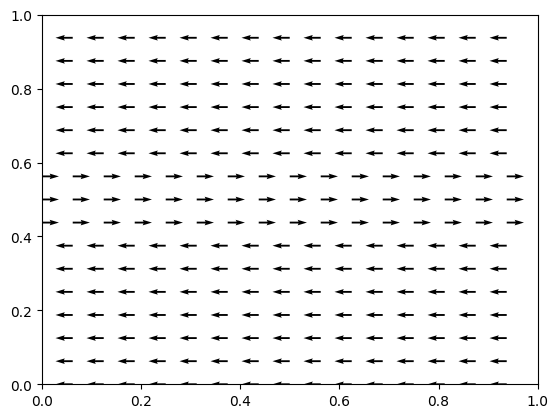

In [289]:
import matplotlib.pyplot as plt
u = convert_to_VF2D(convert_quimb_to_MPS(MPS_U_quimb))
v = convert_to_VF2D(convert_quimb_to_MPS(MPS_V_quimb))
# Genaral parameters
n = 10                          # number of qubits
N = 2**n                        # number of grid points
dx = 1 / (N-1)                  # finite spacing
x = np.linspace(0, 1-dx, N)
y = np.linspace(0, 1-dx, N)
Y, X = np.meshgrid(y, x)
n_s = 2**(n-4)                  # Plot N/n_s number of arrows

plt.figure()
plt.quiver(X[::n_s, ::n_s], Y[::n_s, ::n_s], u[::n_s, ::n_s], v[::n_s, ::n_s], color="black")
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

In [290]:
dx = 1 / (2**10-1)
Diff_2_8_x = Diff_2_8_x_MPO(10, dx)
test = MPS_U_quimb & Diff_2_8_x

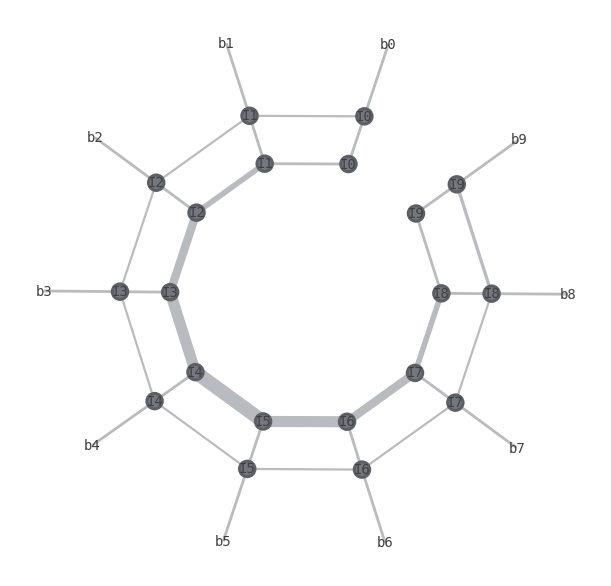

In [291]:
test.draw()

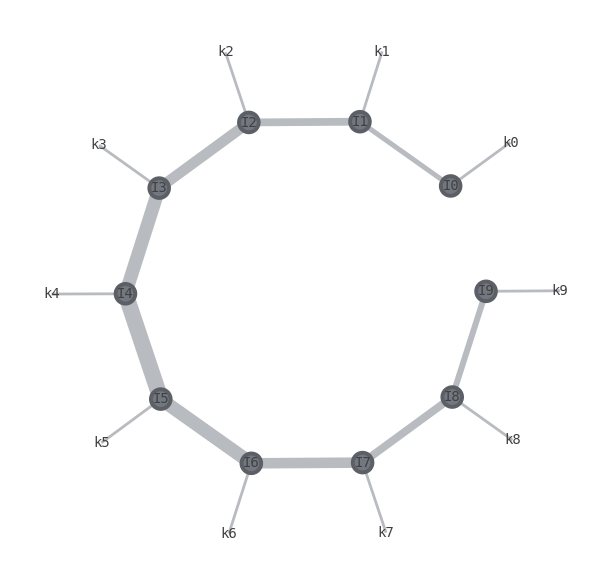

In [300]:
test_2 = Diff_2_8_x.apply(MPS_U_quimb).draw()